<h2>Table of contents</h2>
<ol>
    <a href="#section-preprocessing"><li style="font-size:large;font-weight:bold">Pre-processing & Feature Extraction</li></a>
    <a href="#section-training"><li style="font-size:large;font-weight:bold">Training and Results Analysis</li></a>
    <a href="#section-optional"><li style="font-size:large;font-weight:bold">Linear Model Interpretability</li></a>
    
</ol>

<a name="section-preprocessing"></a><h2 style="color:rgb(0,120,170)">Pre-processing & Feature Extraction</h2>

In [3]:
# !python -m spacy download en_core_web_sm
# !pip install spacy
# !pip install torchtext
# !python -m spacy download en_core_web_md
#!pip install gensim

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchtext
from sklearn.metrics import accuracy_score, confusion_matrix

import nltk
import spacy
import gensim
import re
import string

import copy
import os

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject


## Preprocessing

In [4]:
# Appending headers to the .txt files

def add_headers(full_pth='nlpwdl2021_data/thedeep.small.test.txt'):
    '''
    Function to append header to the text files

    Arguments:
    :full_pth: full path to the text file, str

    Return:
    Saves processed file in the root folder
    '''
    sep, ext = os.path.splitext(full_pth)
    sep = sep.split('/')

    with open(full_pth, 'r', encoding='utf-8') as f:
        text = f.read()

    text = text.split('\n')
    text.insert(0, 'id, text, label') # append headers, final file is readable by pandas

    with open(f'{sep[1]}_processed.txt', 'w+') as f:
        for sentence in text:
            f.write(sentence + '\n')

add_headers('nlpwdl2021_data/thedeep.small.test.txt'), add_headers('nlpwdl2021_data/thedeep.small.train.txt'), add_headers('nlpwdl2021_data/thedeep.small.validation.txt')
train_df, test_df, val_df = pd.read_csv('thedeep.small.train_processed.txt'), pd.read_csv('thedeep.small.test_processed.txt'), pd.read_csv('thedeep.small.validation_processed.txt')


 	Train	Test	Validation
Size	8400	1800	1800


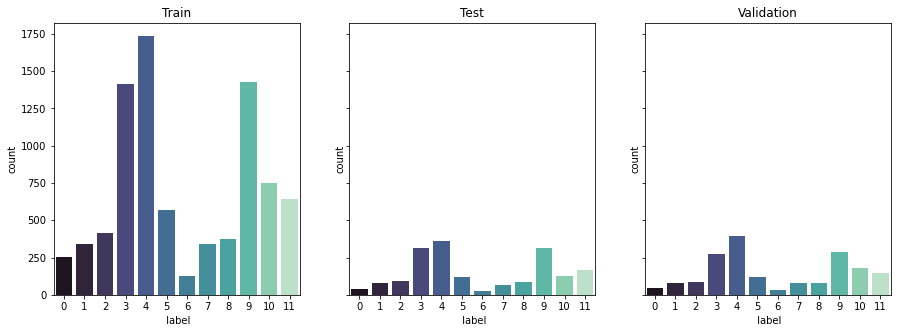

In [5]:
print(' ','Train', 'Test', 'Validation', sep='\t')
print('Size',len(train_df), len(test_df), len(val_df), sep='\t')

fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 5))
ax = ax.flatten()

for df, title, i in zip([train_df, test_df, val_df], ['Train', 'Test', 'Validation'], range(0, 3)):
    figure = sns.countplot(data=df, x=df.iloc[:, 2], palette='mako', ax=ax[i])
    figure.set_title(title)

In [6]:
# Preprocessing steps:
# 1. Convert text to lowercase
# 2. Remove numbers, punctuation and white spaces. Reason to not include the numbers is to not flood the dictionary.


# def preprocess(text):
#     text = text.lower() # convert to lowercase
#     text = text.strip() # remove whitespaces
#     #text = text.translate(str.maketrans('', '', string.punctuation))
#     text = re.sub(r'\d+', '<num>', text) # match and replace all the numbers with tags using regex
#     return text

# print(train_df[train_df['id'] == 2710].iloc[:, 1].values[0])
# print(preprocess(train_df[train_df['id'] == 2710].iloc[:, 1].values[0]))
print(train_df.iloc[:, 1].values[0])
train_df.head(5)

Cholera Daily Situation Report as of 4 November 2017Highlights- 6 additional suspected cholera cases were reported.- No death reported.- No case reported from Dikwa for OVER 3 weeks.- No Alert.  Epidemiological Summary- Total number of suspected cases of cholera reported stands at 5305, with 61 deaths (CFR = 1.2%). 2660 cases in the Muna corridor (Jere LGA), 736 cases in Dikwa, 1756 cases in Monguno, cases in MMC and Mafa stands at 58 and 20 respectively. 1 new cases reported from Guzamala (Guworam) today, and the cumulative for Guzamala stand at 75 cases.- Out of the 274 samples tested using RDTs, 220 (80%) were positive while 120 (64%) of 187 samples were culture positive.


,id,text,label
0,6615,Cholera Daily Situation Report as of 4 Novembe...,4
1,659,"12 321 people affected, five deaths, one perso...",10
2,8591,Violent clashes and inter-communal tensions ha...,3
3,8373,AT least 12 people have been killed and severa...,5
4,10125,"Unidentified gunmen attacked a civilian home, ...",9


In [7]:
# Cleaning and tokenizing text
train_text_series = train_df.iloc[:, 1]
nlp = spacy.load('en_core_web_md') # load spacy nlp vocab

def lemmatize(text):
    '''
    Function to lemmatize the text string and convert it into list of lemmas (tokens).
    
    '''
    doc = nlp(text)
    lemma_list = [token.lemma_ for token in doc] # lemmatize the text (tokenization and normalization)
    return lemma_list

def process(text):
    '''
    Function for text preprocessing. Removes stop-words, punctuation, numbers and converts everything
    except abbreviations to lower case.
    
    '''
    lemma_list = lemmatize(text)
    
    # remove stopwords
    filtered_sentence = []
    for word in lemma_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)

    # remove punctuation
    punctuations = string.punctuation
    for word in filtered_sentence:
        if word in punctuations:
            filtered_sentence.remove(word)

    # convert to lower case
    for word in filtered_sentence:
        if not bool(re.search(r'[A-Z]{2,}', word)): # avoid converting abbreviations to lower case
            filtered_sentence[filtered_sentence.index(word)] = word.lower()

    # substitute numbers
    for word in filtered_sentence:
        token = re.sub(r'(\d+[,.-]*)', '', word)
        token = re.sub(r'[-,.]+', '', token)
        filtered_sentence[filtered_sentence.index(word)] = token
    
    # remove remaining punctuation and whitespaces
    filtered_sentence = [t for t in filtered_sentence if len(t) >= 2]
    return filtered_sentence


train_df_copy, test_df_copy, val_df_copy = copy.deepcopy(train_df), copy.deepcopy(test_df), copy.deepcopy(val_df)

train_df_copy.iloc[:, 1] = train_df_copy.iloc[:, 1].apply(lambda x: process(x))
test_df_copy.iloc[:, 1] = test_df_copy.iloc[:, 1].apply(lambda x: process(x))
val_df_copy.iloc[:, 1]  = val_df_copy.iloc[:, 1].apply(lambda x: process(x))

#### For preprocessing we decided to get rid of the punctuation, stopping words and numbers, as they don't bring any useful information for statistical models. Also, all the text was converted into lowercase, except abbreviations, to avoid duplicates of the same words with capital letters and without.

#### In the cell below, effect of preprocessing on the text can be seen on example from the training set.


In [8]:
# Showing the effects of preprocessing

sample_num = 0
train_df_copy.iloc[:, 1]
print('Original text: ', train_df.iloc[:, 1][sample_num], ' ', 'Preprocessed text: ', train_df_copy.iloc[:, 1][sample_num], sep='\n')

Original text: 
Cholera Daily Situation Report as of 4 November 2017Highlights- 6 additional suspected cholera cases were reported.- No death reported.- No case reported from Dikwa for OVER 3 weeks.- No Alert.  Epidemiological Summary- Total number of suspected cases of cholera reported stands at 5305, with 61 deaths (CFR = 1.2%). 2660 cases in the Muna corridor (Jere LGA), 736 cases in Dikwa, 1756 cases in Monguno, cases in MMC and Mafa stands at 58 and 20 respectively. 1 new cases reported from Guzamala (Guworam) today, and the cumulative for Guzamala stand at 75 cases.- Out of the 274 samples tested using RDTs, 220 (80%) were positive while 120 (64%) of 187 samples were culture positive.
 
Preprocessed text: 
['cholera', 'daily', 'situation', 'report', 'november', 'highlights', 'additional', 'suspect', 'cholera', 'case', 'reported', 'death', 'reported', 'case', 'report', 'dikwa', 'weeks', 'alert', 'epidemiological', 'summary', 'total', 'number', 'suspect', 'case', 'cholera', 'report

## Creating a dictionary

In [9]:
# Creating a vocabulary
def create_count_vocab(series):
    counts = {}
    
    if type(series) == pd.Series:
        series = series.values
    
    for text in series:
        for word in text:
            if word not in counts.keys():
                counts[word] = 1
            else:
                counts[word] += 1
                
    vocab = [x for x in counts.keys()]
    return vocab, counts


vocab_lemmatized, counts_lemmatized = create_count_vocab([lemmatize(text) for text in train_df.iloc[:, 1]]) # examples

train_vocab_reduced, train_counts_reduced = create_count_vocab(train_df_copy.iloc[:, 1])
test_vocab_reduced, test_counts_reduced = create_count_vocab(test_df_copy.iloc[:, 1])
val_vocab_reduced, val_counts_reduced = create_count_vocab(val_df_copy.iloc[:, 1])

len(train_counts_reduced), len(test_counts_reduced), len(val_counts_reduced)
# counts_lemmatized = sorted(counts_lemmatized.items(), key=lambda x: x[1], reverse=False) # used for debug
# train_counts_reduced = sorted(train_counts_reduced.items(), key=lambda x: x[1], reverse=False) # used for debug

(17749, 8560, 8585)

In [10]:
THRESHOLD = 25

def substitute_oov(series:pd.Series, vocab:list, counts:dict):
    '''
    Function to remove OOV words from vocabulary, as well as from text.
    '''
    series = copy.deepcopy(series)
    vocab = copy.deepcopy(vocab)
    vocab_to_remove = []
       
    for sentence_idx in range(len(series)):
        for word in series[sentence_idx]:
            if counts[word] < THRESHOLD:
                vocab_to_remove.append(word)
                series[sentence_idx] = list(filter(lambda a: a != word, series[sentence_idx]))
   
    vocab_to_remove = set(vocab_to_remove)
    vocab = [word for word in vocab if word not in vocab_to_remove]
    return series, vocab

train_X, train_vocab = substitute_oov(train_df_copy.iloc[:, 1], train_vocab_reduced, train_counts_reduced)
test_X, test_vocab = substitute_oov(test_df_copy.iloc[:, 1], test_vocab_reduced, test_counts_reduced)
val_X, val_vocab = substitute_oov(val_df_copy.iloc[:, 1], val_vocab_reduced, val_counts_reduced)

#### We create two types of dictionaries - one with counts for each word and one vocabulary containing every single word in the preprocessed data. We decided to take out the words that occur less than $THRESHOLD$ times in dataset, and remove them completely from vocabulary.

In [11]:
# Showing the effects of OOV removal

sample_num = 64
print('Original text: ', train_df.iloc[:, 1][sample_num], ' ', f'Length of stemmed vocabulary: {len(vocab_lemmatized)}', ' ', 'Preprocessed text: ', train_df_copy.iloc[:, 1][sample_num], ' ', f'Length of stemmed and additionally preprocessed vocabulary: {len(train_vocab_reduced)}', ' ', 'Removed OOVs: ', train_X[sample_num], ' ', f'Length of preprocessed vocabulary with dropped OOVs: {len(train_vocab)}',  sep='\n')

Original text: 
As the security situation in Derna escalated in the second half of May 2018, local population have been dis- placed to the sourrounding areas of Martuba, Shahat, Al Qubba, Soussa, Tobruk and Al Bayda.  Over the past 24 hours, another 115 households (~575 individuals) were reportedly displaced to Tobruk, Shahat, Al Qubba and Al Bayda, bringing the total number of displaced from Derna over the past two weeks to 540 families (~2,700 individuals). Reported priority needs in Martuba, Soussa and Al Qubba include food, NFIs and basic medical supplies. The humanitarian situation inside Derna remains critical. Population movements between the suburbs and the center of Derna, due to continued shelling, reportedly affected at least 500 families in May.
 
Length of stemmed vocabulary: 23667
 
Preprocessed text: 
['security', 'situation', 'derna', 'escalate', 'second', 'half', 'local', 'population', 'dis', 'place', 'sourrounde', 'area', 'martuba', 'shahat', 'al', 'qubba', 'soussa', 

## Creating sentence vectors

### We weighted our datasets with two vectorization techniques - tf and tf-idf

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer


# Tf-idf vectorization
tf_idf_vectorizer = TfidfVectorizer(vocabulary=train_vocab, tokenizer=lambda x: x, lowercase=False)

# Token Weighting 1: High Dimensional
tf_idf_doc_train, tf_idf_doc_test, tf_idf_doc_val = tf_idf_vectorizer.fit_transform(train_X), tf_idf_vectorizer.fit_transform(test_X), tf_idf_vectorizer.fit_transform(val_X)

print(tf_idf_vectorizer)
print("The sparsity rate of train set is", 100*(1 - len(tf_idf_doc_train.nonzero()[0])/np.prod(tf_idf_doc_train.shape)), "%")
print("The sparsity rate of test set is", 100*(1 - len(tf_idf_doc_test.nonzero()[0])/np.prod(tf_idf_doc_test.shape)), "%")
print("The sparsity rate of val set is", 100*(1 - len(tf_idf_doc_val.nonzero()[0])/np.prod(tf_idf_doc_val.shape)), "%")

TfidfVectorizer(lowercase=False,
                tokenizer=<function <lambda> at 0x00000238808C7EE0>,
                vocabulary=['cholera', 'daily', 'situation', 'report',
                            'november', 'additional', 'suspect', 'case',
                            'reported', 'death', 'alert', 'epidemiological',
                            'total', 'number', 'stand', 'CFR', 'corridor',
                            'LGA', 'monguno', 'respectively', 'new', 'today',
                            'cumulative', 'sample', 'test', 'use', 'positive',
                            'culture', 'people', 'affect', ...])
The sparsity rate of train set is 98.61808785529715 %
The sparsity rate of test set is 98.98797014068333 %
The sparsity rate of val set is 98.98165374677002 %


In [13]:
# Tf vectorization
tf_vectorizer = CountVectorizer(vocabulary=train_vocab, tokenizer=lambda x: x, lowercase=False)

# Token Weighting 2: High Dimensional
tf_doc_train, tf_doc_test, tf_doc_val = tf_vectorizer.fit_transform(train_X), tf_vectorizer.fit_transform(test_X), tf_vectorizer.fit_transform(val_X)

print(tf_vectorizer)
print("The sparsity rate of train set is", 100*(1 - len(tf_doc_train.nonzero()[0])/np.prod(tf_doc_train.shape)), "%")
print("The sparsity rate of test set is", 100*(1 - len(tf_doc_test.nonzero()[0])/np.prod(tf_doc_test.shape)), "%")
print("The sparsity rate of val set is", 100*(1 - len(tf_doc_val.nonzero()[0])/np.prod(tf_doc_val.shape)), "%")

CountVectorizer(lowercase=False,
                tokenizer=<function <lambda> at 0x0000023882F5E820>,
                vocabulary=['cholera', 'daily', 'situation', 'report',
                            'november', 'additional', 'suspect', 'case',
                            'reported', 'death', 'alert', 'epidemiological',
                            'total', 'number', 'stand', 'CFR', 'corridor',
                            'LGA', 'monguno', 'respectively', 'new', 'today',
                            'cumulative', 'sample', 'test', 'use', 'positive',
                            'culture', 'people', 'affect', ...])
The sparsity rate of train set is 98.61808785529715 %
The sparsity rate of test set is 98.98797014068333 %
The sparsity rate of val set is 98.98165374677002 %


In [14]:
tf_doc_train.shape, tf_idf_doc_train.shape

((8400, 1935), (8400, 1935))

## Dimensionality reduction

In [15]:
from sklearn import decomposition

k = 25

model = decomposition.TruncatedSVD(n_components = k)

# Token Weighting 1: Low Dimensional
reduced_tfidfdoc_train, reduced_tfidfdoc_test, reduced_tfidfdoc_val = model.fit_transform(tf_idf_doc_train), model.fit_transform(tf_idf_doc_test), model.fit_transform(tf_idf_doc_val)

# Token Weighting 2: Low Dimensional
reduced_tfdoc_train, reduced_tfdoc_test, reduced_tfdoc_val = model.fit_transform(tf_doc_train), model.fit_transform(tf_doc_test), model.fit_transform(tf_doc_val)

### Define label variables

In [16]:
train_y, test_y, val_y = train_df_copy.iloc[:, 2], test_df_copy.iloc[:, 2], val_df_copy.iloc[:, 2]

<a name="section-training"></a><h2 style="color:rgb(0,120,170)">Training and Results Analysis</h2>

## Baseline

In [17]:
from collections import Counter

class Most_Frequent_Classifier:
    def __init__(self, labels):
        self.labels = labels
        labels_freq = Counter(self.labels)
        self.most_freq_label = max(labels_freq.values())
        self.summed_freq_labels = sum(labels_freq.values())
    
    def predict(self):
        return self.most_freq_label / self.summed_freq_labels
    
mfc = Most_Frequent_Classifier(test_y)
mfc.predict()

0.20055555555555554

In [18]:
from sklearn import dummy

dummy_model = dummy.DummyClassifier()
dummy_model.fit(tf_doc_train, train_y)
dummy_model.score(tf_doc_test, test_y)

0.20055555555555554

### Slightly better baseline

In [19]:
import sklearn.naive_bayes as naive_bayes

naive = naive_bayes.MultinomialNB()
naive.fit(tf_idf_doc_train, train_y).score(tf_idf_doc_test, test_y)

0.5783333333333334

## Training and tuning classifiers

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import time
from sklearn.metrics import plot_confusion_matrix

vector_variations = [(tf_idf_doc_train, tf_idf_doc_test, tf_idf_doc_val, 'Tf-idf High Dimensional'),
                     (reduced_tfidfdoc_train, reduced_tfidfdoc_test, reduced_tfidfdoc_val, 'Tf-idf Low Dimensional'),
                     (tf_doc_train, tf_doc_test, tf_doc_val, 'Tf High Dimensional'),
                     (reduced_tfdoc_train, reduced_tfdoc_test, reduced_tfdoc_val, 'Tf Low Dimensional')]


models = [('Random Forest', RandomForestClassifier()), 
          ('SGD', SGDClassifier()), 
          ('Support Vector',SVC())]

params = [{"n_estimators":[100, 250, 500],
           "max_depth": [10, 20, 30, 50]},
          
          {"loss" : ["hinge", "squared_hinge", "modified_huber"],
           "alpha" : [0.0001, 0.001, 0.01, 0.1], 
           "penalty" : ["l2", "l1", "none"]},
          
          {'C': [0.1, 1, 5, 10],
           'gamma': [1.5, 1, 0.1, 0.01],
           'kernel': ['rbf']}]


columns_gridsearch = ['Vector Variation', 'Model', 'Best Hyperparameters', 'Best Training Score', 'Searching Time']
columns_test_val = ['Vector Variation', 'Model', 'Validation Accuracy', 'Test Accuracy']

training_results_dataframe = pd.DataFrame(columns=columns_gridsearch)
test_val_results_dataframe = pd.DataFrame(columns=columns_test_val)
conf_matrices = []

total_time_start = time.time()

for data in vector_variations:
    params_idx = 0
    for model in models:
        time_start = time.time() # start search time
        print(f'Started searching hyperparameters for {model[0]}, Vector variation {data[3]}')


        # grid search model training
        grid = GridSearchCV(model[1], param_grid=params[params_idx], n_jobs=2, cv=3)
        grid.fit(data[0], train_y)

        time_end = time.time() # end search time
        result_time = time.strftime("%H:%M:%S", (time.gmtime(time_end-time_start)))
        print(f'Best model: {str(grid.best_estimator_)}')
        print(f'Searching finished in: {result_time}', '\n')

        # get val and test prediction scores, create confusion matrices
        val_preds, test_preds = grid.predict(data[2]), grid.predict(data[1])
        val_score, test_score = accuracy_score(val_y, val_preds), accuracy_score(test_y, test_preds)

        # save confidence matrices
        confidence_val, confidence_test = confusion_matrix(val_y, val_preds), confusion_matrix(test_y, test_preds)
        conf_matrices.append((confidence_val, confidence_test, model[0], data[3]))


        # recording the results
        res_dict = {'Vector Variation':data[3],
                    'Model': model[0],
                    'Best Hyperparameters': str(grid.best_estimator_),
                    'Best Training Score': grid.best_score_,
                    'Searching Time': result_time}

        test_val_dict = {'Vector Variation':data[3],
                         'Model': model[0],
                         'Validation Accuracy': round(val_score, 4),
                         'Test Accuracy': round(test_score, 4)}

        training_results_dataframe = training_results_dataframe.append(res_dict, ignore_index=True)
        test_val_results_dataframe = test_val_results_dataframe.append(test_val_dict, ignore_index=True)

        params_idx += 1

total_time_end = time.time()
print('Total time of search: ', time.strftime("%H:%M:%S", (time.gmtime(total_time_end-total_time_start))))

training_results_dataframe

Started searching hyperparameters for Random Forest, Vector variation Tf-idf High Dimensional
Best model: RandomForestClassifier(max_depth=50, n_estimators=500)
Searching finished in: 00:04:44 

Started searching hyperparameters for SGD, Vector variation Tf-idf High Dimensional
Best model: SGDClassifier(alpha=0.001, loss='modified_huber')
Searching finished in: 00:00:55 

Started searching hyperparameters for Support Vector, Vector variation Tf-idf High Dimensional
Best model: SVC(C=5, gamma=0.1)
Searching finished in: 00:06:04 

Started searching hyperparameters for Random Forest, Vector variation Tf-idf Low Dimensional
Best model: RandomForestClassifier(max_depth=30, n_estimators=500)
Searching finished in: 00:02:31 

Started searching hyperparameters for SGD, Vector variation Tf-idf Low Dimensional
Best model: SGDClassifier(alpha=0.001, penalty='none')
Searching finished in: 00:01:05 

Started searching hyperparameters for Support Vector, Vector variation Tf-idf Low Dimensional
Best

,Vector Variation,Model,Best Hyperparameters,Best Training Score,Searching Time
0,Tf-idf High Dimensional,Random Forest,"RandomForestClassifier(max_depth=50, n_estimat...",0.613452,00:04:44
1,Tf-idf High Dimensional,SGD,"SGDClassifier(alpha=0.001, loss='modified_huber')",0.640119,00:00:55
2,Tf-idf High Dimensional,Support Vector,"SVC(C=5, gamma=0.1)",0.634881,00:06:04
3,Tf-idf Low Dimensional,Random Forest,"RandomForestClassifier(max_depth=30, n_estimat...",0.608452,00:02:31
4,Tf-idf Low Dimensional,SGD,"SGDClassifier(alpha=0.001, penalty='none')",0.606071,00:01:05
5,Tf-idf Low Dimensional,Support Vector,"SVC(C=5, gamma=1.5)",0.622738,00:01:11
6,Tf High Dimensional,Random Forest,"RandomForestClassifier(max_depth=50, n_estimat...",0.612619,00:03:25
7,Tf High Dimensional,SGD,SGDClassifier(alpha=0.01),0.639762,00:03:08
8,Tf High Dimensional,Support Vector,"SVC(C=5, gamma=0.01)",0.620000,00:06:57
9,Tf Low Dimensional,Random Forest,"RandomForestClassifier(max_depth=30, n_estimat...",0.581429,00:02:27


In [37]:
test_val_results_dataframe

,Vector Variation,Model,Validation Accuracy,Test Accuracy
0,Tf-idf High Dimensional,Random Forest,0.5978,0.6128
1,Tf-idf High Dimensional,SGD,0.6228,0.6378
2,Tf-idf High Dimensional,Support Vector,0.6272,0.6372
3,Tf-idf Low Dimensional,Random Forest,0.3850,0.4639
4,Tf-idf Low Dimensional,SGD,0.3450,0.3928
5,Tf-idf Low Dimensional,Support Vector,0.3311,0.4117
6,Tf High Dimensional,Random Forest,0.6000,0.6100
7,Tf High Dimensional,SGD,0.6194,0.6372
8,Tf High Dimensional,Support Vector,0.6128,0.6167
9,Tf Low Dimensional,Random Forest,0.2522,0.1100


In [36]:
test_val_results_dataframe.loc[np.argmax(test_val_results_dataframe['Test Accuracy'])]

Vector Variation       Tf-idf High Dimensional
Model                                      SGD
Validation Accuracy                     0.6228
Test Accuracy                           0.6378
Name: 1, dtype: object

### Comments on classifiers performance:
Judging from accuracies on validation and test sets, the best performing model in our opinion is SGD and it doesn't take too much time to train as well. Interestingly, accuracy of models on validation sets are sometimes higher than on test sets. This could be due to similarities train and test set distributions, while validation set's distribution was less similar. Overall, all three classifiers surpassed 'slightly better' baseline (Naive Bayes model) if vectors are highly dimensional. In lower dimensional case, models with Tf-idf weighted vectors yielded below 46% accuracy on test set, while models with Tf weighted vectors didn't even surpass the Dummy Classifier.

## Confusion matrices


In [25]:
conf_matrices[0]

(array([[  8,   0,   0,  19,   3,   5,   0,   0,   0,   3,   3,   3],
        [  1,   4,   2,  13,   9,   1,   0,   1,   1,  38,   5,   7],
        [  0,   1,  56,   2,   6,   0,   0,   1,   0,  11,   3,   3],
        [  1,   1,   2, 217,  11,   8,   0,   0,   8,  15,   3,   8],
        [  0,   2,   7,  13, 328,   1,   0,   0,   5,  26,   4,  11],
        [  5,   1,   1,  47,   7,  18,   0,   3,   1,  24,   8,   7],
        [  0,   0,   0,   2,   3,   0,   0,   0,   0,  16,  10,   1],
        [  0,   0,   1,   9,  13,   0,   0,  11,   0,  15,  22,   5],
        [  0,   0,   0,  13,  12,   2,   0,   0,  44,   5,   0,   1],
        [  0,   1,   5,  13,  22,   1,   0,   4,   0, 230,   5,   5],
        [  1,   2,   5,  12,   9,   3,   1,   4,   1,  43,  88,  10],
        [  0,   1,   0,  22,  33,   3,   1,   1,   2,  10,   3,  72]],
       dtype=int64),
 array([[  8,   0,   0,  14,   5,   7,   0,   1,   1,   2,   1,   3],
        [  0,   6,   0,  10,   9,   0,   0,   3,   1,  27,  17,   7]

4


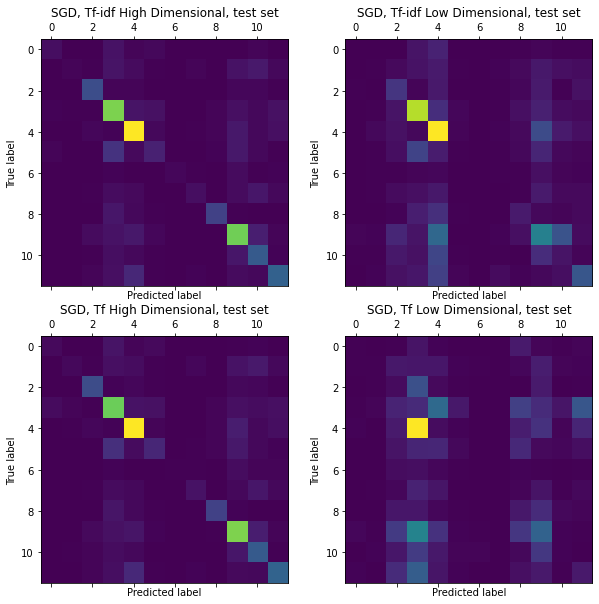

4


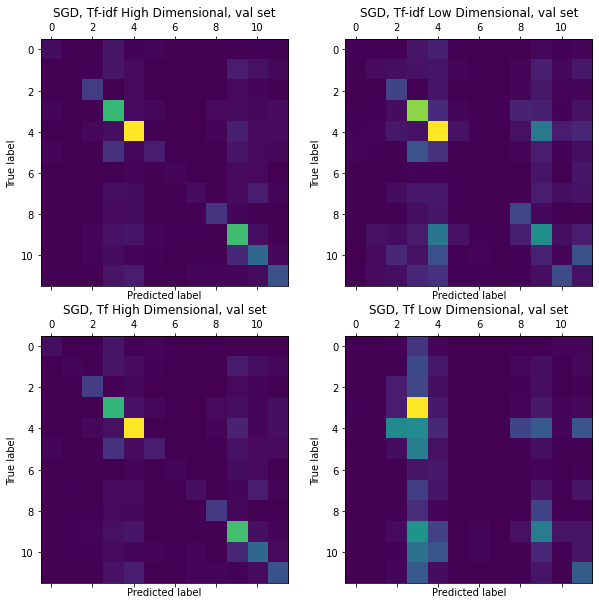

(None, None)

In [26]:
def plot_confusion(conf_list=conf_matrices, clf_name='SGD', mode='test'):
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
    axs = axs.flatten()
    selected_clfs = [i for i in conf_matrices if i[2] == clf_name]
    print(len(selected_clfs))
    for e, (conf_val, conf_test, name, vector_var) in enumerate(selected_clfs):
        if mode == 'test':
            axs[e].matshow(conf_test)
            axs[e].title.set_text(f'{name}, {vector_var}, {mode} set')
            axs[e].set_ylabel('True label')
            axs[e].set_xlabel('Predicted label')
        elif mode == 'val':
            axs[e].matshow(conf_val)
            axs[e].title.set_text(f'{name}, {vector_var}, {mode} set')
            axs[e].set_ylabel('True label')
            axs[e].set_xlabel('Predicted label')
    plt.show()
    
plot_confusion(), plot_confusion(mode='val')

SGD performed the worst on the classes 0, 1, 5, 6, 7 and 8, which is expected, as they are very underpopulated in the training set, as well as in validation and test sets.

## Features visualization

In [27]:
from sklearn.manifold import TSNE

best_model = SGDClassifier(alpha=0.001, loss='modified_huber')
best_model.fit(tf_idf_doc_train, train_y)
predictions = best_model.predict(tf_idf_doc_test)

vis_model = TSNE(n_components=2, random_state=28)
projected_vectors = vis_model.fit_transform(tf_idf_doc_test)

In [28]:
tf_idf_doc_test.shape, test_y.shape

((1800, 1935), (1800,))

In [29]:
correct = [e for e,(i,j) in enumerate(zip(predictions, test_y)) if i == j]
incorrect = [e for e,(i,j) in enumerate(zip(predictions, test_y)) if i != j]
arr = np.array(test_y)
arr[correct], arr[incorrect] = 1, 0

In [30]:
projected_vectors.shape

(1800, 2)

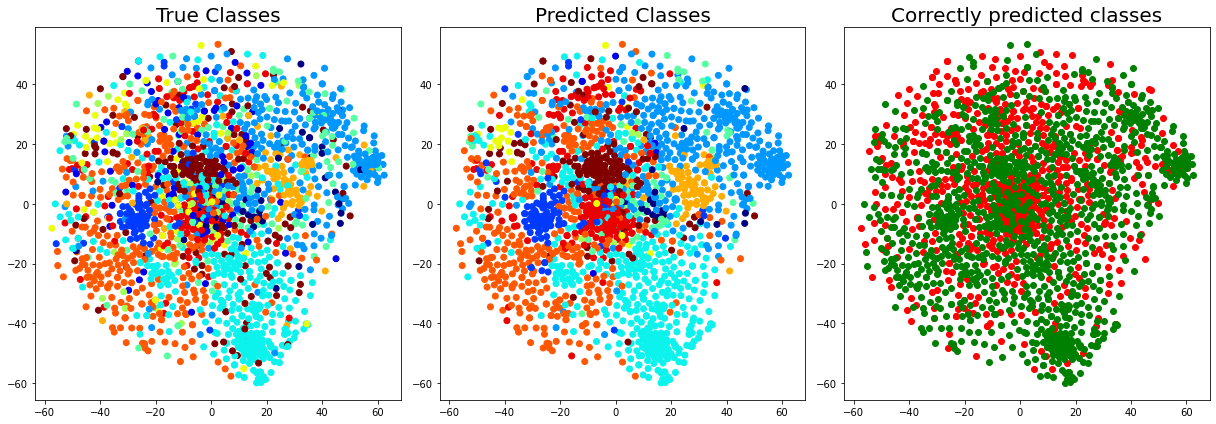

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 6))

axes[0].scatter(projected_vectors[:, 0], projected_vectors[:, 1], c=test_y, 
                cmap=plt.cm.get_cmap("jet", np.max(test_y)+1))
axes[0].set_title("True Classes", fontsize=20)

axes[1].scatter(projected_vectors[:, 0], projected_vectors[:, 1], c=predictions, 
                cmap=plt.cm.get_cmap("jet", np.max(predictions)+1))
axes[1].set_title("Predicted Classes", fontsize=20)


axes[2].scatter(projected_vectors[incorrect, 0], projected_vectors[incorrect, 1],
                cmap=plt.cm.get_cmap("jet", np.max(test_y)+1), color='red')
axes[2].scatter(projected_vectors[correct, 0], projected_vectors[correct, 1], 
                cmap=plt.cm.get_cmap("jet", np.max(test_y)+1), color='green')
axes[2].set_title("Correctly predicted classes", fontsize=20)


fig.tight_layout()
plt.show()

In general, classifier had problems with discerning classes that have high variance. Some of the classes were also underpopulated in the dataset. Nevertheless, model learned good decision boundaries to separate classes.

<a name="section-optional"></a><h2 style="color:rgb(0,120,170)">Linear Model Interpretability</h2>

In [56]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(tf_idf_doc_train, train_y)
lr.score(tf_idf_doc_test, test_y)

C:\Users\bollo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6361111111111111

In [81]:
top_3_arr = []
for i in range(lr.coef_.shape[0]):
    max_idcs = np.argpartition(lr.coef_[i], -3)[-5:]
    top_3s = {train_vocab[x]:lr.coef_[i][x] for x in max_idcs}
    top_3_arr.append((top_3s, i))
top_3_arr

[({'agricultural': 2.38763292051349,
   'hectare': 2.423793406944491,
   'farmer': 2.547881270700906,
   'agriculture': 2.564350335297884,
   'crop': 3.5454790235906324},
  0),
 ({'poverty': 1.425348674659209,
   'support': 1.554178733305515,
   'humanitarian': 1.5850859409340614,
   'disaster': 1.8678722885455035,
   'situation': 1.6800465282312098},
  1),
 ({'child': 2.2942408718707084,
   'learning': 3.0075491158942866,
   'teacher': 3.311451102773019,
   'education': 5.937576270308091,
   'school': 8.770639036613936},
  2),
 ({'pastoral': 1.1031143271016193,
   'maize': 2.682717107947344,
   'IPC': 2.791447380864409,
   'WFP': 2.9551748161251394,
   'food': 8.172877005515733},
  3),
 ({'patient': 3.347516233236478,
   'cholera': 4.007800876107325,
   'hospital': 4.1034756661752425,
   'case': 5.7516555867593295,
   'health': 5.866790115461648},
  4),
 ({'cash': 1.736251807506809,
   'farmer': 2.437634386023176,
   'income': 2.784230745086073,
   'livestock': 3.5796828715958284,
   

<ipython-input-101-5422772f0794>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i[1]].set_xticklabels(i[0].keys(), rotation = 40, size=14)


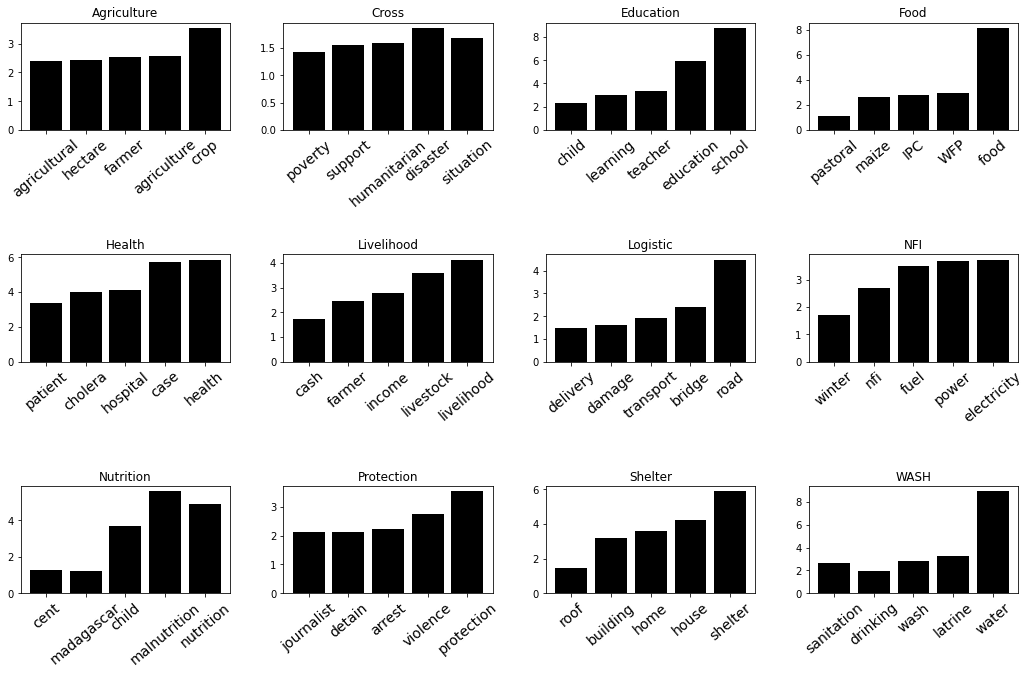

In [101]:
labels_dict = {
    0:'Agriculture',
    1:'Cross',
    2:'Education',
    3:'Food',
    4:'Health',
    5:'Livelihood',
    6:'Logistic',
    7:'NFI',
    8:'Nutrition',
    9:'Protection',
    10:'Shelter',
    11:'WASH'
}
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15,10))
ax = ax.flatten()
for i in top_3_arr:
    ax[i[1]].bar(i[0].keys(), i[0].values(), color='black')
    ax[i[1]].title.set_text(f'{labels_dict[i[1]]}')
    ax[i[1]].set_xticklabels(i[0].keys(), rotation = 40, size=14)
fig.tight_layout(pad=3.0)